In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools

import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg

from scipy.stats import mode
dy_name = 'Figures'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    DJ.makedir(private_out)


import vapeplot
from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerBase
from matplotlib.transforms import Bbox, TransformedBbox,blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,BboxConnectorPatch

# Other functions


In [122]:
def vc_unique_add_proportion(df, gb, col_unique):
    """groupby two categories, and count the number of unique elements in the third
    and proportion of total unique elements"""
    vc = df.groupby((gb[0], gb[1]))[col_unique].apply(lambda x: len(set(x))).to_frame('count').reset_index()
    vc_tot = df.groupby(gb[0])[col_unique].apply(lambda x: len(set(x))).to_frame('total')
    vc = vc[vc[gb[1]] == True]
    vc = vc.set_index(gb[0])
    vc = vc.join(vc_tot)
    vc['fraction'] = vc['count'] / vc['total']
    return vc

def vc_w_prop(df, gb_col, bool_col):
    vc = df.groupby(gb_col)[bool_col].value_counts().to_frame('count')
    vc_frac = df.groupby(gb_col)[bool_col].value_counts(normalize = True).to_frame('fraction')
    vc = vc.join(vc_frac)
    vc = vc.reset_index()
    tot = vc.groupby(gb_col)['count'].sum().to_frame('total')
    
    vc = vc[vc[bool_col] == True] 
    
    vc = vc.set_index(gb_col).join(tot)
    vc = vc.reset_index()
    return vc

# Plotting Functions

In [2]:

from matplotlib.transforms import Bbox, TransformedBbox,blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,BboxConnectorPatch
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b, 
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, alpha=0.1, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = alpha

    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p, prop_patches


In [3]:
def zoom_effect03(ax1, ax2, xmin, xmax, ymin=False, ymax=False, alpha=0.1, fill = False, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """
    
    ymin_ax2, ymax_ax2 = ax2.get_ylim()
        
    if not ymin:
        ymin = ymin_ax2
    
    if not ymax:
        ymax = ymax_ax2
        
    
    
    trans1 = blended_transform_factory(ax1.transData, ax1.transData)
    trans2 = blended_transform_factory(ax2.transData, ax2.transData)

    bbox = Bbox.from_extents(xmin, ymin, xmax, ymax)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = alpha
#     prop_patches["fc"] = 'green'
    

    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)
        
    p.set_fill(fill)
    
    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p



In [4]:
def zoom_effect04(ax1, ax2, xmin1 = False, xmax1 = False, xmin2 = False, xmax2 = False ,
                  ymin1=False, ymax1=False, ymin2=False, ymax2 = False, alpha=0.1,
                  fill_connector = False, fill_p1 = True, fill_p2 = True, **kwargs):
    
    ymin_ax2, ymax_ax2 = ax2.get_ylim()
    if not ymin2:
        ymin2 = ymin_ax2

    if not ymax2:
        ymax2 = ymax_ax2
        
     
    xmin_ax2, xmax_ax2 = ax2.get_xlim()
    if not xmin2:
        xmin2 = xmin_ax2
    if not xmax2:
        xmax2 = xmax_ax2
    
    ymin_ax1, ymax_ax1 = ax1.get_ylim()
    
    if not ymin1:
        ymin1 = ymin_ax1

    if not ymax1:
        ymax1 = ymax_ax1
        
    xmin_ax1, xmax_ax1 = ax1.get_xlim()
    if not xmin1:
        xmin1 = xmin_ax1
    if not xmax1:
        xmax1 = xmax_ax1
    
    
    trans1 = blended_transform_factory(ax1.transData, ax1.transData)
    trans2 = blended_transform_factory(ax2.transData, ax2.transData)

    bbox1 = Bbox.from_extents(xmin1, ymin1, xmax1, ymax1)
    bbox2 = Bbox.from_extents(xmin2, ymin2, xmax2, ymax2)

    mybbox1 = TransformedBbox(bbox1, trans1)
    mybbox2 = TransformedBbox(bbox2, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = alpha
#     prop_patches["fc"] = 'green'

    
#      'upper right'  : 1,
#         'upper left'   : 2,
#         'lower left'   : 3,
#         'lower right'  : 4
    
    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)

    p.set_fill(fill_connector)
    bbox_patch1.set_fill(fill_p1)
    bbox_patch2.set_fill(fill_p2)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

In [5]:
from matplotlib.legend_handler import HandlerBase


def get_text_handles_for_legend(ax, texts, labels, size = 10,
                               color = 'black', x= 0, y= 0):
    
    handles = []
    
    for t in texts:
        tx = ax.text(x=0, y=0, zorder =1, s=t, color=color, size=size, ha="right", )
        handles.append(tx)
    

    class TextHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,xdescent, ydescent,
                            width, height, fontsize,trans):
            h = copy.copy(orig_handle)
            h.set_position((width/2.,height/2.))
            h.set_transform(trans)
            h.set_ha("center");
            h.set_va("center");
            fp = orig_handle.get_font_properties().copy()
            
            fp.set_size(fontsize)
    
            # uncomment the following line, 
            # if legend symbol should have the same size as in the plot
#             h.set_font_properties(fp)
            return [h]

    
    handlermap = {type(handles[0]) : TextHandler()}
    
    return handles, labels, handlermap

def annotateBars(ax, supplied_labels = False, 
                 offset_points_y = 20, rotation = 90,
                color = 'gray', fontsize = 8): 
    
    count = 0
    for p in ax.patches:
        height = p.get_height()
        direction = 1
        if height < 0:
            direction = -1
            
        if supplied_labels:
            lab = supplied_labels[count]
            
        else:
            lab = "%.2f" % p.get_height()
        ax.annotate(lab ,(p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=fontsize, color=color, rotation=rotation, 
                    xytext=(0, (direction) * offset_points_y),
                 textcoords='offset points')
        
        count += 1
#         print p.get_xy(), p.get_height()
    return p

In [6]:
def get_bbox_extent_including_texts(ax,fig):
    renderer = mpl.tight_layout.get_renderer(fig)
    inset_tight_bbox = ax.get_tightbbox(renderer)
    # inv_transform = ax2.transAxes.inverted()
    inv_fig = fig.transFigure.inverted()
    c = inv_fig.transform(inset_tight_bbox)
    x0, y0 = c[0]
    xmax, ymax  = c[1]

    w = xmax - x0
    h = ymax - y0

    rect = [x0, y0, w, h]
    
    pos = ax.get_position()
    w_pad = w - pos.width
    h_pad = h - pos.height
    
    x0_pad = x0 - pos.x0
    xmax_pad = xmax - pos.xmax
    
    y0_pad = y0 - pos.y0
    ymax_pad = ymax - pos.ymax
    
    d = {'x0':x0, 'y0':y0, 'width':w, 'height':h, 'xmax':xmax , 'ymax': ymax, 'rect': rect, 'w_pad' :w_pad,
        'h_pad' : h_pad, 'x0_pad': x0_pad, 'y0_pad': y0_pad, 'xmax_pad': xmax_pad, 'ymax_pad': ymax_pad}
#     return x0, y0, w, h, xmax, ymax, rect
    return d

def get_offset_coord(ax, fig, bbox_loc = [0,1], x=-2, y  = 6, units = 'points'):

    inv = ax.transData.inverted()
    
    inv_fig = fig.transFigure.inverted()

    # specify the number of points or inches or dots to transform by
    # places an axes transform here for the axes on which you want to pick an anchor point on
    offsetter = mpl.transforms.offset_copy(ax.transAxes, fig=fig, x= x, y= y, units =units)

    # offset an anchor point - this will return display coordinates 
    corner_offset = offsetter.transform(bbox_loc)
    fig_coord = inv_fig.transform(corner_offset)
    return fig_coord


In [434]:
def resize_axes(ax1, fig, bbox_loc = [0,0], x=0, y  = 0, units = 'points', scale_factor= 1.1, w_pad = False,
                h_pad = False, resize_from_fixed = False, expand_from_corner = True, 
                scale_ax = False, square_on_width = False, square_on_height = False, expand_bottom_left=True):
    """resize an axis either by scaling, or shrinking height or width, 
    change bbox_loc and offset to control where the scaling comes from, and if desired move the plot
    allows you to expand plot from middle or from the corner of plot in any direction"""
    coord = get_offset_coord(ax1, fig, bbox_loc=bbox_loc, x = x, y = y, units = units)
    pos = ax1.get_position()
    w = pos.width
    h = pos.height
#     w_original = pos.width
#     h_original = pos.height
    width_fig, height_fig  = fig.get_size_inches()
    ratio_w = width_fig/height_fig
    ratio_h = height_fig/width_fig
    
    if scale_ax != False:
        pos3 = scale_ax.get_position()
        w = pos3.width
        h = pos3.height
        
    if scale_factor:
        w = pos.width * scale_factor
        h = pos.height * scale_factor
    
    if square_on_height:
        w = h * ratio_h
    elif square_on_width:
        h = w * ratio_w
    else:
        pass
        
    if w_pad:
        w += w_pad
    if h_pad:
        h += h_pad

    x0, y0 = coord[0], coord[1]
    
    h_delt = pos.height- h
    w_delt = pos.width - w
    
    if resize_from_fixed:
        y0_update = y0 + h_delt
        x0_update = x0 + w_delt
        ax1.set_position([x0_update, y0_update, w, h])
    
    elif expand_from_corner:
        if expand_bottom_left:
            ax1.set_position([coord[0], coord[1], w, h])
            
        else:
            ax1.set_position([coord[0]-abs(w_delt), coord[1]- abs(h_delt), w, h])
            
    else:
        pass

In [7]:
def offset_keep_bounds(ax1, ax2, fig, bbox_offset = [1,0], offset_from_top_left = False,
                       x=-2, y  = 6, units = 'points',
           match_height = False, match_width= False, 
                       offset_from_extents = False, offset_type = 'right', 
            use_offset_edge = True, pad_tick_length = 3.5):

    coord2 = get_offset_coord(ax2, fig, bbox_loc = bbox_offset, x = x, y = y, units = units)
    coord1 = get_offset_coord(ax1, fig, bbox_loc=[0,0], x = 0, y = 0, units = units)


    pos = ax1.get_position()
    pos2 = ax2.get_position()
    w2 = pos2.width
    h2 = pos2.height

    w = pos.width
    h = pos.height
    if offset_from_extents:
        d2 = get_bbox_extent_including_texts(ax2, fig)
        d1 = get_bbox_extent_including_texts(ax1, fig)
        h2_tight = d2['height']
        w2_tight = d2['width']

        h1_tight = d1['height']
        w1_tight = d1['width']

        x0_pad_1 = abs(d1['x0_pad'])
        xmax_pad_1 = d1['xmax_pad']
        y0_pad_1 = d1['y0_pad']
        ymax_pad_1 = d1['ymax_pad']

        x0_pad_2 = abs(d2['x0_pad'])
        xmax_pad_2 = d2['xmax_pad']
        y0_pad_2 = d2['y0_pad']
        ymax_pad_2 = d2['ymax_pad']

        if offset_type == 'right':

            pad = xmax_pad_2 + x0_pad_1
            coord2[0] = coord2[0] + pad
            w = pos.xmax - coord2[0]
        if offset_type == 'top':
            pad = abs(y0_pad_1) + ymax_pad_2
            coord2[1] = coord2[1] + pad
            h = pos.ymax - coord2[1] 
        if offset_type == 'bottom':
            pad = abs(y0_pad_2) + ymax_pad_1
            coord2[1] = coord2[1] - pad
            h = coord2[1] - pos.y0
        if offset_type == 'left':
            pad = xmax_pad_1 + x0_pad_2
            coord2[0] = coord2[0] - pad
            w = coord2[0] - pos.x0

    if use_offset_edge:
        if offset_type == 'bottom':
            coord2[1] = coord2[1] - h
        if offset_type == 'left':
            coord2[0] = coord2[0] - w
            
    

    if match_height:
        h = h2
    if match_width:
        w = w2
        
    
    if offset_type in {'left', 'right'}:
        ax1.set_position([coord2[0], coord1[1], w, h])
    else:
        ax1.set_position([coord1[0], coord2[1], w, h])

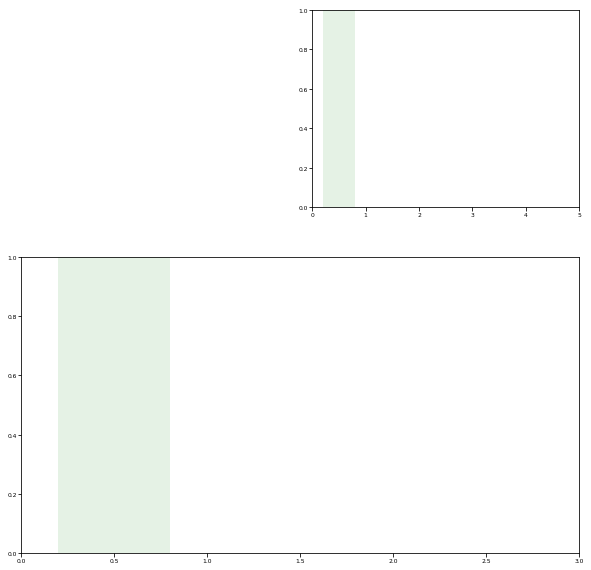

In [538]:
fig = plt.figure(figsize = (10,10))
gs0 = mpl.gridspec.GridSpec(2, 4, height_ratios= [2,3])
ax1 = fig.add_subplot(gs0[0,2:])
ax2 = fig.add_subplot(gs0[1,:])

ax2.set_xlim(0, 3)
ax1.set_xlim(0, 5)

c1, c2, p1, p2, cp, pp = zoom_effect01(ax1, ax2, 0.2, 0.8, fc = 'green', color = 'green', ec ='none', fillconne)



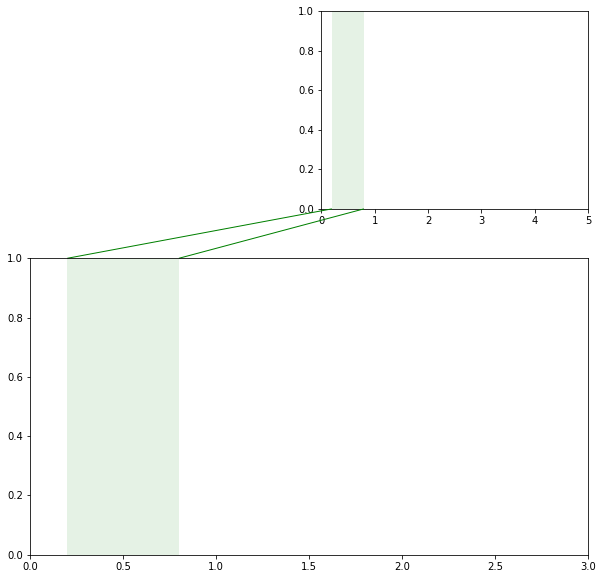

In [8]:
fig = plt.figure(figsize = (10,10))
gs0 = mpl.gridspec.GridSpec(2, 4, height_ratios= [2,3])
ax1 = fig.add_subplot(gs0[0,2:])
ax2 = fig.add_subplot(gs0[1,:])

ax2.set_xlim(0, 3)
ax1.set_xlim(0, 5)

c1, c2, p1, p2, cp, pp = zoom_effect01(ax1, ax2, 0.2, 0.8, fc = 'green', color = 'green', ec = 'green')



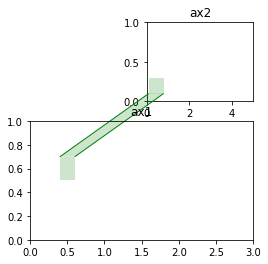

In [9]:
fig = plt.figure(figsize = (4,4))
gs0 = mpl.gridspec.GridSpec(2, 4, height_ratios= [2,3])
ax2 = fig.add_subplot(gs0[0,2:])
ax1 = fig.add_subplot(gs0[1,:])
ax1.set_title('ax1')
ax2.set_title('ax2')

ax1.set_xlim(0, 3)
ax2.set_xlim(0, 5)
c1, c2, p1, p2, cp = zoom_effect04(ax2, ax1, xmin1=0.1, xmax1=0.8, xmin2=0.4, xmax2=0.6, ymin1= 0.1, ymax1=0.3, 
                                   ymin2 = 0.5, ymax2 = 0.7, fc = 'green', color = 'green', ec = 'green',  
                                   alpha = 0.2, fill_connector = True, fill_p1 = True, fill_p2 = True)

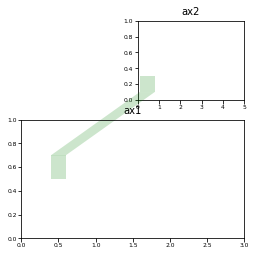

In [541]:
fig = plt.figure(figsize = (4,4))
gs0 = mpl.gridspec.GridSpec(2, 4, height_ratios= [2,3])
ax2 = fig.add_subplot(gs0[0,2:])
ax1 = fig.add_subplot(gs0[1,:])
ax1.set_title('ax1')
ax2.set_title('ax2')

ax1.set_xlim(0, 3)
ax2.set_xlim(0, 5)
c1, c2, p1, p2, cp = zoom_effect04(ax2, ax1, xmin1=0.1, xmax1=0.8, xmin2=0.4, xmax2=0.6, ymin1= 0.1, ymax1=0.3, 
                                   ymin2 = 0.5, ymax2 = 0.7, fc = 'green', color = 'green', ec = 'none',  
                                   alpha = 0.2, fill_connector = True, fill_p1 = True, fill_p2 = True)

In [ ]:
 fc = 'purple',ec= 'purple', color = 'purple',
                                   alpha = 0.1, fill_connector = True, fill_p1 = True, fill_p2 = False)

# Data Import

In [1]:
def add_svtype_cats(all_qtls_filt):
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV', 'SNV': 'SNV', 'INDEL_DEL': 'INDEL', 
               'INDEL_INS': 'INDEL'}
    all_qtls_filt['SVTYPE_SUPER'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'SV'))
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV',
               'ALU': 'MEI', 'LINE1': 'MEI', 'SVA':'MEI', 'rMEI':'rMEI', 
          'DUP': 'CNV', 'DEL': 'CNV', 'mCNV': 'CNV', 'SNV': 'SNV', 'INDEL_INS': 'INDEL', 'INDEL_DEL': 'INDEL', 
              'INDEL': 'INDEL', 'SNP': "SNV"}
    all_qtls_filt['SVTYPE_COLLAPSE'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'other SV'))
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI'}
    all_qtls_filt['SVTYPE_NR_C'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x))
    
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI', 'DUP': 'CNV', 'DEL': 'CNV', 'mCNV': 'CNV'}
    all_qtls_filt['SVTYPE_NR_C2'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x))
    
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV', 'INV': 'other SV', 'BND': 'other SV',
               'ALU': 'MEI', 'LINE1': 'MEI', 'SVA':'MEI', 'rMEI':'rMEI', 
          'DUP': 'DUP', 'DEL': 'DEL', 'mCNV': 'mCNV', 'SNV': 'SNV', 'INDEL_INS': 'INDEL', 'INDEL_DEL': 'INDEL', 
              'INDEL': 'INDEL', 'SNP': "SNV"}
    all_qtls_filt['SVTYPE_NR_C3'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x)) 
    
    
    
    return all_qtls_filt

In [133]:
enr_int_pc_pqtl_svt_lead = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v4/enr_int_pc_pqtl_svt_lead.pkl')

In [462]:
enr_int_pc_pqtl_svt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v4/enr_int_pc_pqtl_svt.pkl')

In [132]:
t1 = vc_w_prop(var_egene_nr_nc_nd[var_egene_nr_nc_nd.int_distal_pc_10kb == True], 'SVTYPE_NR_C', 'significant') 
t2 = vc_w_prop(var_egene_nr_nc_nd[var_egene_nr_nc_nd.int_distal_pc_10kb == False], 'SVTYPE_NR_C', 'significant') 
t1['intersects_anchor'] = True
t2['intersects_anchor'] = False
vc_pqtl_da_nc_svonly  = pd.concat([t1,t2])

t1 = vc_w_prop(var_egene_nr_nc_nd[var_egene_nr_nc_nd.int_distal_pc_10kb == True], 'SVTYPE_NR_C', 
               'top_hit_final_sig') 
t2 = vc_w_prop(var_egene_nr_nc_nd[var_egene_nr_nc_nd.int_distal_pc_10kb == False], 'SVTYPE_NR_C', 
               'top_hit_final_sig') 
t1['intersects_anchor'] = True
t2['intersects_anchor'] = False
vc_pqtl_da_nc_svonly_th   = pd.concat([t1,t2])

In [39]:
num_loops_per_egene_mat = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/num_loops_per_egene_mat.pkl')

In [87]:
var_egene_nr_nc_nd = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v4/var_egene_nr_nc_nd.pkl')

In [31]:
per_variant_info  = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/per_variant_info_annot_update.pkl')

In [32]:
fn_loop_illust = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/loop_distance_illustration_v2.png'

In [41]:
enr_n_loops_nearby_all_th = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v4/enr_n_loops_nearby_all_th.pkl')

enr_n_loops_nearby_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v4/enr_n_loops_nearby_all.pkl')

In [465]:
enr_hit_anchor_lead = enr_int_pc_pqtl_svt_lead[enr_int_pc_pqtl_svt_lead.int_distal_pc_10kb].set_index('SVTYPE_NR_C', 
                                                                                                 drop = False)


In [466]:
enr_hit_anchor = enr_int_pc_pqtl_svt[enr_int_pc_pqtl_svt.int_distal_pc_10kb].set_index('SVTYPE_NR_C', 
                                                                                                 drop = False)

# Prep for Pie Chart

In [ ]:
var_egene_nr = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_enrichments/qtl_results_01_17_v4/var_egene_nr.pkl').pipe(add_svtype_cats)

var_egene_nr = var_egene_nr.pipe(add_svtype_cats)

var_egene_nr_nc_nd = var_egene_nr_nc_nd.pipe(add_svtype_cats)
var_egene_nr_nc_nd['overlaps_anchor'] = (var_egene_nr_nc_nd.min_dist_pc_anchor <= 10000)
inds = var_egene_nr_nc_nd[(var_egene_nr_nc_nd.significant) & (var_egene_nr_nc_nd.overlaps_anchor == True)].gene_var_id.unique()
var_egene_nr['nd_nc_sig'] = var_egene_nr.gene_var_id.isin(inds)
var_egene_nr['SVTYPE_NR_C_pie'] = var_egene_nr.SVTYPE_NR_C

inds = var_egene_nr[~var_egene_nr.nd_nc_sig].index.tolist()
var_egene_nr.loc[inds, 'SVTYPE_NR_C_pie'] = 'non-loop distal eQTLs'

inds = var_egene_nr[(~var_egene_nr.nd_nc_sig) & (var_egene_nr.genic_category_variant != 'intergenic')].index.tolist()
var_egene_nr.loc[inds, 'SVTYPE_NR_C_pie'] = 'genic eQTLs'

inds = var_egene_nr[(var_egene_nr.nd_nc_sig)].index.tolist()
var_egene_nr.loc[inds, 'SVTYPE_NR_C_pie'] = 'loop acting eQTLs'

p1 = var_egene_nr[var_egene_nr.significant].groupby("SVTYPE_NR_C_pie").size()

p2 = var_egene_nr[var_egene_nr.nd_nc_sig].groupby("SVTYPE_NR_C3").size()

p2 = p2.sort_values()

# Pallette and orders

In [8]:
color_pal_svtypes_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/color_pal_svtypes_all.pkl')
color_pal_svtypes_all = color_pal_svtypes_all.apply(lambda x: mpl.colors.rgb2hex(x))

color_pal_svtypes_all['CNV'] = '#ffef96'
color_pal_svtypes_all['other SV'] = '#f4e1d2'
order_vars_c = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'MEI', 'STR', 'BND']
order_vars_c_filt = ['DEL', 'DUP', 'mCNV', 'rMEI', 'MEI', 'STR', 'BND']

# Paper Figure

In [37]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.2
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['axes.labelpad'] = 1
mpl.gridspec.rcParams['ytick.major.pad'] = 1
mpl.gridspec.rcParams['xtick.major.pad'] = 1
mpl.gridspec.rcParams['axes.titlesize'] = 10
mpl.gridspec.rcParams['axes.labelsize'] = 7
mpl.gridspec.rcParams['ytick.labelsize'] = 6
mpl.gridspec.rcParams['xtick.labelsize'] = 6
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'
mpl.gridspec.rcParams['grid.linewidth'] = 0.5
mpl.gridspec.rcParams['font.size'] = 7
mpl.gridspec.rcParams['legend.facecolor'] = 'white'

In [35]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

In [36]:
fn_loop_example = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/loop_locus_examples/locus_images_v2/locus_Human_STR_906007.png'

In [12]:
log_norm = LogNorm(vmin=1, vmax=500)

In [53]:
yt = map(lambda x: round(x,3), np.arange(0,0.025, 0.005))

In [54]:
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.it'] = 'STIXGeneral:italic'
mpl.rcParams['mathtext.bf'] = 'STIXGeneral:bold'

[0.0, 0.005, 0.01, 0.015, 0.02]

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/frazer01/home/djakubosk

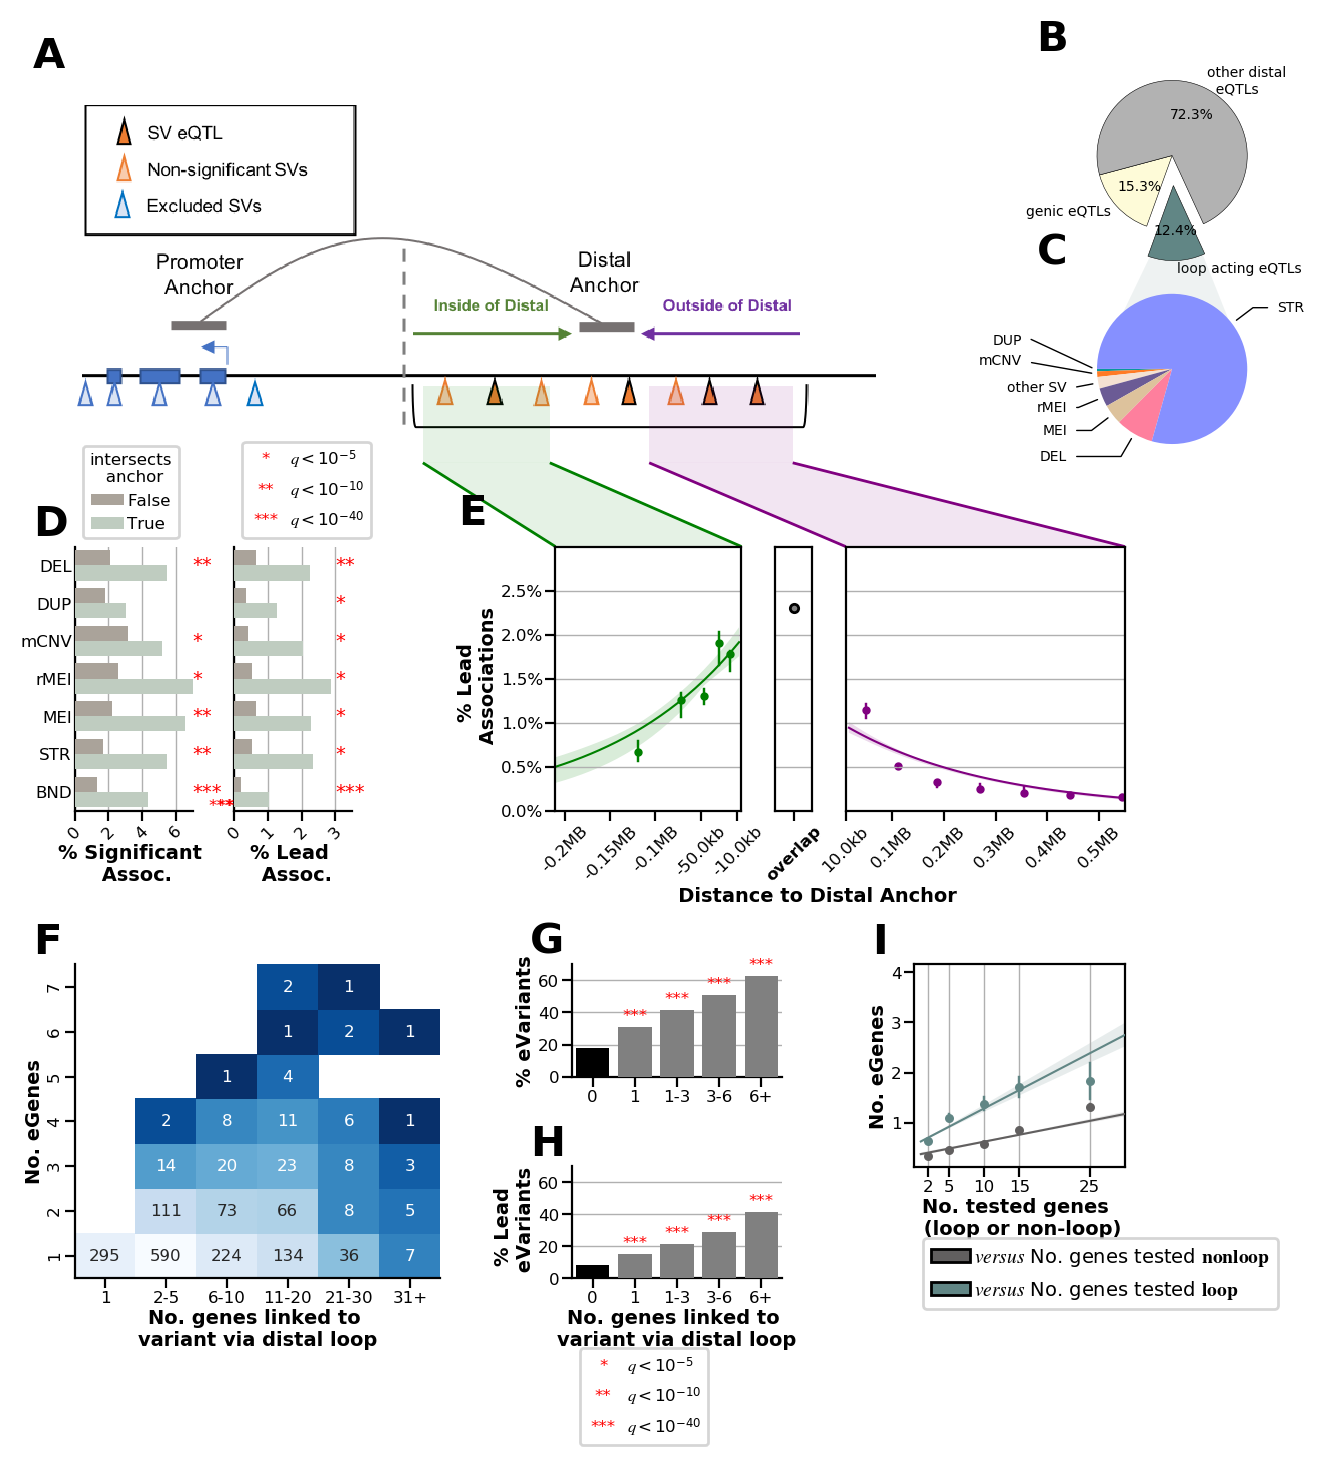

In [599]:
fig =plt.figure(figsize=(7,7), dpi = 200)
gs = mpl.gridspec.GridSpec(6, 6, 
                           figure =fig, height_ratios = [1, 1, 0.6, 0.6, 1, 1], 
                           width_ratios= [1,0.6,1,1.5,1,1], wspace = 0.1,
                           hspace=1.5)


ax1 = fig.add_subplot(gs[0:2, 0:4], zorder = 0, facecolor = (0,0,0,0))

subgrid_t = mpl.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs[0:2, 4:6], wspace=0.35,
                                               hspace= 0.25)

# subgrid_t_b = mpl.gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs[0:2,2:4], wspace=0.1,
#                                                hspace= 0.35, width_ratios = [1,0.2 ,1.5])


subgrid1 = mpl.gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs[2:4,0:2], wspace=0.35,
                                               hspace= 0.35, width_ratios = [1,1])

subgrid1_b = mpl.gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs[2:4,2:5], wspace=0.2,
                                               hspace= 0.35, width_ratios = [1,0.2 ,1.5])

# ax2_a = fig.add_subplot(subgrid1[0,0], aspect = 'equal')
# ax2_b = fig.add_subplot(subgrid1[1,0], aspect = 'equal')


ax3_a = fig.add_subplot(subgrid1[:, 0])
ax3_b = fig.add_subplot(subgrid1[:, 1])


ax4_a = fig.add_subplot(subgrid1_b[0])
ax4_b = fig.add_subplot(subgrid1_b[1])
ax4_c =  fig.add_subplot(subgrid1_b[2])

# subgrid2 = mpl.gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gs[:4, 4:6], wspace=0.8, 
#                                                 height_ratios = [1, 0.5],
#                                                hspace= 0.5, width_ratios = [1, 1, 0.5])

subgrid2 = mpl.gridspec.GridSpecFromSubplotSpec(4,4, subplot_spec=gs[4:6,0:5], wspace=0.8,
                                               hspace= 1.4, width_ratios = [1, 1, 1.8, 1.8],
                                               height_ratios= [0.05, 1,0.5,0.5])

subgrid2_l = mpl.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=subgrid2[1:, 2], wspace=0.8,
                                               hspace= 0.8)


ax5 = fig.add_subplot(subgrid2[1:,0:2])
# ax6 = fig.add_subplot(subgrid2[1, 2])
# ax7 = fig.add_subplot(subgrid2[2:, 2])
                                                  
ax6 = fig.add_subplot(subgrid2_l[0])
ax7 = fig.add_subplot(subgrid2_l[1])
ax8 = fig.add_subplot(subgrid2[1:-1, 3])


im = mpimg.imread(fn_loop_illust)
ax1.imshow(im, zorder = 0, alpha = 1, aspect = 'equal')


# ax2_a = fig.add_subplot(gs[0, 4:6])

# ax2_b = fig.add_subplot(gs[1, 4:6])

ax2_a = fig.add_subplot(subgrid_t[0])
ax2_b = fig.add_subplot(subgrid_t[1])


# resize_axes(ax8, fig, bbox_loc=[0,0], expand_from_corner=True, expand_bottom_left=False, scale_factor=1.15)
# resize_axes(ax7, fig, bbox_loc=[0,0], expand_from_corner=True, scale_factor=1.15, expand_bottom_left=False)



#################### Pie Charts #########################
ax = ax2_a
colors = ['#fefbd8', '#618685', '#b2b2b2']
patches, texts, autotext = ax.pie(p1, labels = p1.index, startangle = 195, 
                                  explode=[0,0.4,0], autopct='%1.1f%%',
                                  colors=colors, textprops = {'fontsize': 5})

for patch in patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(0.5)

for t in texts:
    t.set_fontsize(5)
    lab =  t.get_text()
    if lab == 'non-loop distal eQTLs':
        t.set_text('other distal\n  eQTLs')
    
    
colors = [color_pal_svtypes_all[i] for i in p2.index]
ax = ax2_b


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0, alpha = 0)
kw = dict(arrowprops=dict(arrowstyle="-", lw = 0.5),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))


# patches, texts, autotext = ax.pie(p2, labels = p2.index, startangle = 180, autopct='%1.1f%%',
#                                   colors=colors, explode = [0.2,0.2,0.2,0,0,0,0.2])

wedges, texts = ax.pie(p2, startangle = 180,
                                   colors=colors)


for patch in patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(0.2)


for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
#     print y
    x = np.cos(np.deg2rad(ang))
#     print ang
    xm = 1.4
    if i == 0:
        xm = 2
        ang = -25
        horizontalalignment = 'left'
#         ang = 20
        
     

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=45,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(p2.index[i], xy=(x, y), xytext=(xm*np.sign(x), (1.35*(y + 0.3))),
                    horizontalalignment=horizontalalignment, fontsize = 5,**kw )
    elif i == 1:
        xm = 2
        ang = -10
#         y += 0.15
        horizontalalignment = 'left'
#         ang = 20
     

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=5,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(p2.index[i], xy=(x, y), xytext=(xm*np.sign(x), (1.35*(y + 0.15))),
                    horizontalalignment=horizontalalignment, fontsize = 5,**kw )
    else:
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(p2.index[i], xy=(x, y), xytext=(xm*np.sign(x), 1.35*y),
                    horizontalalignment=horizontalalignment, fontsize = 5,**kw )
        

#### plot the distance to loop regressions
yt = map(lambda x: round(x,3), np.arange(0,0.03, 0.005))
for a in [ax4_a, ax4_b, ax4_c]:
    a.set_ylim(0,0.03)
    a.set_yticks(yt)
    a.yaxis.grid(zorder = 0)

for a in [ax4_b, ax4_c]:
    a.set_yticklabels([])
    a.tick_params(axis = 'y', length = 0)
    
for a in [ax2, ax3_a, ax3_b]:
    a.xaxis.grid(zorder = 0)


ax = ax3_a
ax = sns.barplot(y = 'SVTYPE_NR_C', x = 'fraction', data = vc_pqtl_da_nc_svonly, ax = ax, 
            order = order_vars_c_filt, hue = 'intersects_anchor', palette = {True: '#bdcebe', False: '#ada397'},
                 zorder = 20)

# ax3.set_yticklabels([])
ax.set_ylabel('')
ax.tick_params(axis = 'y', length = 0)
ax.set_xlabel('% Significant \n Assoc.')
ax.set_xticks([0, 0.02, 0.04, 0.06])
ax.set_xlim(0,0.07)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=1))

xl = 0.07
for svt, y in zip(order_vars_c, ax.get_yticks()):
    text = enr_hit_anchor.loc[svt, 'fdr_corrected_p']
    c = 'black'
    if text < 0.05:
        c = 'red'
#     if text < 0.001:
    
    if text < 1e-40:
        ax.text(x = xl, y = y, s = "***", ha = 'left', 
               va = 'center', fontsize= 7, color = 'red')
    elif text < 1e-10:
        ax.text(x = xl, y = y, s = "**", ha = 'left', 
               va = 'center', fontsize= 7, color = 'red')
    
    elif text < 0.05:
        ax.text(x = xl, y = y, s = "*", ha = 'left', 
        va = 'center', fontsize= 7, color = 'red')
       
    else: 
        pass

ax = ax3_b
ax = sns.barplot(y = 'SVTYPE_NR_C', x = 'fraction', data = vc_pqtl_da_nc_svonly_th, ax = ax, 
            order = order_vars_c_filt, hue = 'intersects_anchor', palette = {True: '#bdcebe', False: '#ada397'},
                 zorder = 20)

# ax3.set_yticklabels([])
ax.set_ylabel('')
ax.tick_params(axis = 'y', length = 0)
ax.set_xlabel('% Lead \n Assoc.')
ax.set_xticks([0, 0.01, 0.02, 0.03])
ax.set_xlim(0,0.035)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=1))
xl = 0.03
for svt, y in zip(order_vars_c, ax.get_yticks()):
    text = enr_hit_anchor_lead.loc[svt, 'fdr_corrected_p']
    c = 'black'
    if text < 0.05:
        c = 'red'
#     if text < 0.001:
    
    if text < 1e-40:
        ax.text(x = xl, y = y, s = "***", ha = 'left', 
               va = 'center', fontsize= 7, color = 'red')
    elif text < 1e-10:
        ax.text(x = xl, y = y, s = "**", ha = 'left', 
               va = 'center', fontsize= 7, color = 'red')
    
    elif text < 0.05:
        ax.text(x = xl, y = y, s = "*", ha = 'left', 
        va = 'center', fontsize= 7, color = 'red')
       
    else: 
        pass

# ax2.xaxis.set_major_formatter(FuncFormatter(lambda y, _ : '{:.0%}'.format(y))) 
# ax2.xaxis.set_major_formatter(FuncFormatter(lambda y, _ : round((100*y), 0))) 
# ax2.xaxis.set_major_formatter(FuncFormatter(lambda y, _ : int((100*y)))) 
for a in [ax3_a, ax3_b]:
    a.xaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=0)) 
    a.tick_params(axis = 'x', labelrotation = 45)
    sns.despine(ax = a)
ax3_b.set_yticklabels([])
        

## Draw the loop distance plots

with mpl.rc_context({"lines.linewidth": 0.5}):
    ax = ax4_c
    sns.regplot(x = 'min_dist_pc_anchor_mod', y = 'top_hit_final_sig', 
                logistic=True, x_bins=8, x_partial="NMODE_AF",
                data = var_egene_nr_nc_nd[(var_egene_nr_nc_nd.category_min == 'outside_distal') & 
                                          (var_egene_nr_nc_nd.min_dist_pc_anchor > 10000)],
                scatter_kws = {'s':4}, n_boot = 5, ax = ax, color= 'purple')
    
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(10000, 550000)
    xticks = np.arange(0,550000, 100000)
    xticks = [10000] + list(xticks)[1:]
    ax.set_xticks(xticks)
    ax.set_xticklabels(mpltools.format_base_pair_scale(xticks))
    ax.tick_params(axis = 'x', labelrotation = 45)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax = ax4_a
    sns.regplot(x = 'min_dist_pc_anchor_mod', y = 'top_hit_final_sig', 
                logistic=True, x_bins=5, x_partial='NMODE_AF',
                data = var_egene_nr_nc_nd[(var_egene_nr_nc_nd.category_min == 'inside_distal') &
                                         (var_egene_nr_nc_nd.min_dist_pc_anchor > 10000)], 
                n_boot = 5, scatter_kws = {'s':4},
               ax = ax, truncate = True, color = 'green')
    
    
    ax.set_xlim(-210000, -5000)
    t = sorted((np.arange(0, 210000, 50000)[1:] * -1))
    xticks = list(t) + [-10000]
    ax.set_xticks(xticks)
    ax.set_xticklabels(mpltools.format_base_pair_scale(xticks))
    ax.tick_params(axis = 'x', labelrotation = 45)
    ax.set_ylabel('% Lead \n Associations')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1, )) 
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, symbol = None, decimals=1))
    ax.set_xlabel('')
    
ol_frac = (var_egene_nr_nc_nd[(var_egene_nr_nc_nd.min_dist_pc_anchor <= 10000)]
           .top_hit_final_sig.value_counts(normalize = True)[True])

ax4_b.scatter(0.5, ol_frac, marker = 'o', s = 9, edgecolor = 'black', color = 'grey')
ax4_b.set_xticks([0.5])
ax4_b.set_xticklabels(['overlap'],weight = 'bold')
ax4_b.tick_params(axis = 'x', labelrotation = 45)

ax4_b.set_xlabel('       Distance to Distal Anchor')




#### plot heatmap number of loops connected to an eVariant / number of those that are egenes

xticklabels = ['1', '2-5', '6-10', '11-20', '21-30', '31+']
ax5 = sns.heatmap(num_loops_per_egene_mat.T, annot = True, fmt = "0", vmin = 1, vmax = 500, 
                  norm=log_norm, cmap='Blues_r', cbar = False, ax = ax5, annot_kws = {'fontsize':6})

ax5.invert_yaxis()
ax5.spines['left'].set_visible(True)
ax5.spines['bottom'].set_visible(True)
ax5.set_xlabel('No. genes linked to \nvariant via distal loop')

# ax5.set_xlabel('No. Genes Linked By \n Loop To Variant')
ax5.set_ylabel('No. eGenes')
ax5.set_xticklabels(xticklabels)
ax5.set_yticklabels(map(int, ax5.get_yticks()))
ax5.set_yticklabels(range(1,8))




##################################### Plot enrichment of high complexity ###############################
loop_bins = ['0', '1', '1-3', '3-6', '6+']
pal = {k:'grey' for k in loop_bins}
pal['0'] = 'black'
ax6.yaxis.grid(zorder=0)
ax6 = sns.barplot(y = 'fraction', x = 'category', data = enr_n_loops_nearby_all, 
            order = loop_bins, ax = ax6, zorder = 20, palette = pal)
labs = ['', '***', '***', '***', '***']
p = annotateBars(ax6, supplied_labels=labs,  rotation = 0, offset_points_y=4, color = 'red', fontsize=6)

yt = [0, 0.2, 0.4,0.6]
ax6.set_ylim(0, 0.7)
ax6.set_yticks(yt)
ax6.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _ : int((100*y)))) 
ax6.set_ylabel('% eVariants')
ax6.set_xlabel('')
sns.despine(ax = ax6)

        
ax = ax7
ax.yaxis.grid(zorder=0)
ax = sns.barplot(y = 'fraction', x = 'category', data = enr_n_loops_nearby_all_th, 
            order = loop_bins, ax = ax, zorder = 20, palette = pal)
labs = ['', '***', '***', '***', '***']
p = annotateBars(ax7, supplied_labels=labs,  rotation = 0, offset_points_y=4, color = 'red', fontsize=6)

labels_for_leg = [ '*', '**','***']
p_val_labs = [r'$\ q < 10^{-5}$', r'$\ q<10^{-10}$', r'$\ q < 10^{-40}$']

handles, labels, handler_map = get_text_handles_for_legend(ax6, labels_for_leg, p_val_labs, size = 6,
                               color = 'red', x= -1, y = -1)

legend = ax.legend(handles, p_val_labs, handler_map=handler_map, bbox_to_anchor = [0,-0.55], loc = 'upper left',
                   fontsize = 6, ncol = 1) 

for t in handles:
    t.set_visible(False)
ax.set_ylim(0, 0.7)
ax.set_yticks(yt)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _ : int((100*y)))) 
ax.set_ylabel('% Lead \n eVariants')
ax.set_xlabel('')
sns.despine(ax = ax)

ax.set_xlabel('No. genes linked to \nvariant via distal loop')


ax = ax8
ax.xaxis.grid(zorder = 0)
xb = [2, 5, 10, 15, 25]



with mpl.rc_context({"lines.linewidth": 0.5}):
    ax = sns.regplot(y = 'num_egenes', x = 'num_nonloop_tested', data = pvt[pvt.num_nonloop_tested > 0],
               x_bins = xb, label = '$versus$ No. genes tested $\mathbf{nonloop}$',ax = ax,
               truncate = True, color = '#615f5f', scatter_kws = {'s':5, 'zorder':20}, 
                     line_kws = {'zorder':19})


    ax = sns.regplot(y = 'num_egenes', x = 'num_genes_tested_loop', 
                data = pvt[pvt.num_genes_tested_loop > 0], 
                label = '$versus$ No. genes tested $\mathbf{loop}$', x_bins = xb, 
                truncate = True, color = '#618685',
               ax = ax, scatter_kws = {'s':5, 'zorder':20}, line_kws = {'zorder':19})
    ax.set_xticks(xb)
    ax.set_xlim(0, 30)
    ax.set_ylabel('No. eGenes')
    ax.set_xlabel('No. tested genes \n (loop or non-loop)')
    
    colors =['#615f5f','#618685' ]
    labels =  ['$versus$ No. genes tested $\mathbf{nonloop}$', '$versus$ No. genes tested $\mathbf{loop}$']
    handles = mpltools.get_legend_patches(labels, just_rect = True, rectfacecolor=colors)
    
    ax.legend(handles =handles, bbox_to_anchor = (0, -0.3), loc = 'upper left', ncol = 1)

####################### TightLayout and Legend Placements ##########################

gs.tight_layout(fig)
leg = ax3_a.legend(fontsize = 6, title = 'intersects\n   anchor', bbox_to_anchor = (0,1), ncol = 1, loc = 'lower left')
leg.get_title().set_fontsize(6)


labels_for_leg = [ '*', '**','***']
p_val_labs = [r'$\ q < 10^{-5}$', r'$\ q<10^{-10}$', r'$\ q < 10^{-40}$']

tax =  fig.add_axes(ax3_b.get_position(), alpha = 0)
handles, labels, handler_map = get_text_handles_for_legend(tax, labels_for_leg, p_val_labs, size = 6,
                             color = 'red', x= 0, y = 0)
legend = tax.legend(handles, p_val_labs, handler_map=handler_map, bbox_to_anchor = [0,1], 
                      loc = 'lower left', fontsize = 6, ncol = 1)

tax.set_axis_off()
ax3_b.legend().set_visible(False)
# offset_keep_bounds(ax1, ax2, fig, offset_type= 'top', bbox_offset=[0,1], y = 0.2, x = 0, units = 'inches',
#                   offset_from_extents = True)

# offset_keep_bounds(ax8, ax7, fig, offset_type= 'right', bbox_offset=[1,1], y = 0, x = 0.2, units = 'inches',
#                   offset_from_extents = True)

ax1.set_axis_off()
# need another axes with ylims that go min to max, image defaults to reversed ylims and can't be changed 
# without reversing the image... could update my zoom effects to extend from different places to fix such things
tax = fig.add_axes(ax1.get_position(), alpha = 0)
tax.set_xlim(ax1.get_xlim())
tax.set_axis_off()



c1, c2, patch1, patch2, cp = zoom_effect04(tax, ax4_a, xmin2=-210000, xmax2= -5000, 
                                   xmin1=315, xmax1=430, ymin1= 0, ymax1=0.2, 
                                   ymin2 = 0.025, ymax2 = 0.03, fc = 'green', color = 'green', ec = 'green', 
                                   alpha = 0.1, fill_connector = True, fill_p1 = True, fill_p2 = False)

c1, c2, patch1, patch2, cp = zoom_effect04(tax, ax4_c, xmin2=10000, xmax2=550000, 
                                   xmin1=520, xmax1=650, ymin1= 0, ymax1=0.2, 
                                   ymin2 = 0.025, ymax2 = 0.03, fc = 'purple',ec= 'purple', color = 'purple',
                                   alpha = 0.1, fill_connector = True, fill_p1 = True, fill_p2 = False)



resize_axes(ax2_a, fig, square_on_height=True)
resize_axes(ax2_b, fig, square_on_height=True)


c1, c2, patch1, patch2, cp = zoom_effect04(ax2_a, ax2_b, xmin2=-1, xmax2= 1, 
                                   xmin1=-.25, xmax1=0.38, ymin1= -1.25, ymax1= -1.2, 
                                   ymin2 = 0.025, ymax2 = 0.03, fc = '#618685',ec = 'none',
                                   alpha = 0.1, fill_connector = True, fill_p1 = True, fill_p2 = False,
                                          zorder = 0)


labels = ['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I']
for i, a in enumerate([ax1, ax2_a, ax2_b, ax3_a, ax5, ax6, ax7, ax8]):
    mpltools.label_offset_axes(a, fig, labels[i], x = -15, y = 4, )
    
    
    
mpltools.label_offset_axes(ax4_a, fig, 'E', x = -35, y = 8, )    
out_fn = private_out + '/Figure_SVs_at_Chromatin_Loops_v2'
fig.savefig(out_fn, bbox_inches='tight', dpi = 500)